In [1]:
from catboost import CatBoostRegressor, Pool
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import pickle

pd.options.display.max_columns = 200

In [2]:
def read_file(path):
    df = pd.read_excel(path)
    df.columns = df.iloc[4]
    df = df.iloc[5:][df.columns[:-1]]

    columns = df.columns.tolist()

    columns[3] = 'продажи'
    columns[16] = 'заболеваемость'
    columns[33] = 'ТВ реклама, руб'
    columns[35] = 'интернет реклама, руб'
    columns[51] = 'wordstat'

    df.columns = columns
    df.loc[df['неделя']==53, 'неделя'] = 52

    df['Начало нед'] = pd.to_datetime(df['Начало нед'])

    return df

df = read_file('data/train.xlsx')
df.loc[df['неделя']==53, 'неделя'] = 52

In [3]:
df['year'] = df['Начало нед'].dt.year

df.loc[df['year'] <= 2020, 'продажи'] += 5_000_000

In [4]:
# df['money'] = df['Медиа ТВ (Моделироуемый бренд)_(тотал)ТВ, рубли'] + df['Медиа Диджитал (Моделируемый бренд)_Диджитал, рубли']

# plt.figure(figsize=(45, 15))

# cur_df = df[df.value.notna()]
# plt.plot(cur_df['Период_Начало нед'], cur_df['value'] / cur_df['value'].max())
# plt.plot(cur_df['Период_Начало нед'], cur_df['money'] / cur_df['money'].max())
# plt.plot(cur_df['Период_Начало нед'], cur_df['статистика заболеваемости_Статистика заболеваемости'] / cur_df['статистика заболеваемости_Статистика заболеваемости'].max())

# plt.legend(['кол-во продаж', 'кол-во рекламы', 'заболеваемость'])

In [5]:
def create_features(df):

    week_info = df.groupby('неделя')['продажи'].agg(['sum', 'count'])
    week_info.columns = [f'week_{x}' for x in week_info.columns]

    for i in range(29):
        df[f'target_{i+1}'] = df['продажи'].shift(-i) / df['продажи'].shift(1)

    # week_info_dict = week_info.to_dict()
    for i in range(29):
        df['tmp'] = df['неделя'] + i
        df = df.merge(week_info, how='left', right_index=True, left_on='tmp')
        df['week_sum'] -= df['продажи'].shift(-i)
        df['week_count'] -= 1
        df[f'feature_mean_week_{i}'] = df['week_sum'] / df['week_count'] / 10_000_000
        df[f'feature_mean_week_norm_{i}'] = df[f'feature_mean_week_{i}'] / df['продажи'].shift(1) / 10_000_000
        df.drop(['week_sum', 'week_count'], axis=1, inplace=True)

    df['feature_illnesses'] = df['заболеваемость'].shift(1) / 1_000_000

    df['feature_week'] = df['неделя']

    for i in [7, 13, 20]:
        df[f'feature_big_diff_{i}_weeks'] = df['продажи'].shift(1) / df['продажи'].shift(i) / 10_000_000

    bad_cols = [col for col in df.columns if 'feature' not in col and 'target' not in col]
    df.drop(bad_cols, axis=1, inplace=True)
    
    return df

df = create_features(df)

In [6]:
df = df[df['target_1'].notna()].reset_index(drop=True)
df = df.loc[20:].reset_index(drop=True)

In [7]:
df[(df.target_2 > 1.5) | (df.target_2 < 0.7)]

,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,target_11,target_12,target_13,target_14,target_15,target_16,target_17,target_18,target_19,target_20,target_21,target_22,target_23,target_24,target_25,target_26,target_27,target_28,target_29,feature_mean_week_0,feature_mean_week_norm_0,feature_mean_week_1,feature_mean_week_norm_1,feature_mean_week_2,feature_mean_week_norm_2,feature_mean_week_3,feature_mean_week_norm_3,feature_mean_week_4,feature_mean_week_norm_4,feature_mean_week_5,feature_mean_week_norm_5,feature_mean_week_6,feature_mean_week_norm_6,feature_mean_week_7,feature_mean_week_norm_7,feature_mean_week_8,feature_mean_week_norm_8,feature_mean_week_9,feature_mean_week_norm_9,feature_mean_week_10,feature_mean_week_norm_10,feature_mean_week_11,feature_mean_week_norm_11,feature_mean_week_12,feature_mean_week_norm_12,feature_mean_week_13,feature_mean_week_norm_13,feature_mean_week_14,feature_mean_week_norm_14,feature_mean_week_15,feature_mean_week_norm_15,feature_mean_week_16,feature_mean_week_norm_16,feature_mean_week_17,feature_mean_week_norm_17,feature_mean_week_18,feature_mean_week_norm_18,feature_mean_week_19,feature_mean_week_norm_19,feature_mean_week_20,feature_mean_week_norm_20,feature_mean_week_21,feature_mean_week_norm_21,feature_mean_week_22,feature_mean_week_norm_22,feature_mean_week_23,feature_mean_week_norm_23,feature_mean_week_24,feature_mean_week_norm_24,feature_mean_week_25,feature_mean_week_norm_25,feature_mean_week_26,feature_mean_week_norm_26,feature_mean_week_27,feature_mean_week_norm_27,feature_mean_week_28,feature_mean_week_norm_28,feature_illnesses,feature_week,feature_big_diff_7_weeks,feature_big_diff_13_weeks,feature_big_diff_20_weeks
41,1.286044,2.887023,2.567788,1.792488,0.944538,0.85923,0.75815,0.670621,0.603664,0.621504,0.574797,0.554403,0.576432,0.568799,0.646887,0.639573,0.691243,0.737317,0.797774,0.832696,0.850874,0.875579,0.887933,0.860858,0.84765,0.891452,1.126076,1.168066,1.068671,6.639689,0.0,6.207815,0.0,5.874873,0.0,5.895408,0.0,6.015585,0.0,6.016397,0.0,5.94626,0.0,5.530747,0.0,5.04602,0.0,5.370517,0.0,5.367666,0.0,5.521088,0.0,5.733653,0.0,5.694541,0.0,5.68985,0.0,5.803732,0.0,6.031886,0.0,6.131421,0.0,6.074174,0.0,6.049313,0.0,6.31191,0.0,6.607722,0.0,6.783959,0.0,6.709619,0.0,6.932334,0.0,8.294008,0.0,9.576736,0.0,8.859803,0.0,8.048014,0.0,1.203405,11,0.0,0.0,0.0
42,2.244886,1.996656,1.393799,0.734452,0.668119,0.589521,0.521461,0.469396,0.483268,0.446949,0.431092,0.448221,0.442286,0.503005,0.497318,0.537495,0.573322,0.620332,0.647486,0.661621,0.680831,0.690437,0.669385,0.659114,0.693173,0.875612,0.908262,0.830975,0.808551,6.207815,0.0,5.874873,0.0,5.895408,0.0,6.015585,0.0,6.016397,0.0,5.94626,0.0,5.530747,0.0,5.04602,0.0,5.370517,0.0,5.367666,0.0,5.521088,0.0,5.733653,0.0,5.694541,0.0,5.68985,0.0,5.803732,0.0,6.031886,0.0,6.131421,0.0,6.074174,0.0,6.049313,0.0,6.31191,0.0,6.607722,0.0,6.783959,0.0,6.709619,0.0,6.932334,0.0,8.294008,0.0,9.576736,0.0,8.859803,0.0,8.048014,0.0,7.839902,0.0,1.178877,12,0.0,0.0,0.0
43,0.889424,0.620878,0.327167,0.297618,0.262606,0.232288,0.209096,0.215275,0.199097,0.192033,0.199663,0.197019,0.224067,0.221534,0.239431,0.25539,0.276331,0.288427,0.294724,0.303281,0.30756,0.298182,0.293607,0.308779,0.390047,0.404592,0.370164,0.360175,0.367418,5.874873,0.0,5.895408,0.0,6.015585,0.0,6.016397,0.0,5.94626,0.0,5.530747,0.0,5.04602,0.0,5.370517,0.0,5.367666,0.0,5.521088,0.0,5.733653,0.0,5.694541,0.0,5.68985,0.0,5.803732,0.0,6.031886,0.0,6.131421,0.0,6.074174,0.0,6.049313,0.0,6.31191,0.0,6.607722,0.0,6.783959,0.0,6.709619,0.0,6.932334,0.0,8.294008,0.0,9.576736,0.0,8.859803,0.0,8.048014,0.0,7.839902,0.0,7.900407,0.0,1.326045,13,0.0,0.0,0.0
44,0.698067,0.367841,0.334619,0.295254,0.261167,0.235091,0.242038,0.223849,0.215907,0.224486,0.221513,0.251924,0.249075,0.269198,0.287141,0.310685,0.324285,0.331364,0.340986,0.345797,0.335253,0.330109,0.347167,0.438539,0.454892,0.416183,0.404952,0.413096,0.416701,5.895408,0.0,6.015585,0.0

In [8]:
i = 1

cur_df = df.drop([43-i, 44-i, 45-i, 46-i])

cur_df.iloc[35:45]

,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,target_11,target_12,target_13,target_14,target_15,target_16,target_17,target_18,target_19,target_20,target_21,target_22,target_23,target_24,target_25,target_26,target_27,target_28,target_29,feature_mean_week_0,feature_mean_week_norm_0,feature_mean_week_1,feature_mean_week_norm_1,feature_mean_week_2,feature_mean_week_norm_2,feature_mean_week_3,feature_mean_week_norm_3,feature_mean_week_4,feature_mean_week_norm_4,feature_mean_week_5,feature_mean_week_norm_5,feature_mean_week_6,feature_mean_week_norm_6,feature_mean_week_7,feature_mean_week_norm_7,feature_mean_week_8,feature_mean_week_norm_8,feature_mean_week_9,feature_mean_week_norm_9,feature_mean_week_10,feature_mean_week_norm_10,feature_mean_week_11,feature_mean_week_norm_11,feature_mean_week_12,feature_mean_week_norm_12,feature_mean_week_13,feature_mean_week_norm_13,feature_mean_week_14,feature_mean_week_norm_14,feature_mean_week_15,feature_mean_week_norm_15,feature_mean_week_16,feature_mean_week_norm_16,feature_mean_week_17,feature_mean_week_norm_17,feature_mean_week_18,feature_mean_week_norm_18,feature_mean_week_19,feature_mean_week_norm_19,feature_mean_week_20,feature_mean_week_norm_20,feature_mean_week_21,feature_mean_week_norm_21,feature_mean_week_22,feature_mean_week_norm_22,feature_mean_week_23,feature_mean_week_norm_23,feature_mean_week_24,feature_mean_week_norm_24,feature_mean_week_25,feature_mean_week_norm_25,feature_mean_week_26,feature_mean_week_norm_26,feature_mean_week_27,feature_mean_week_norm_27,feature_mean_week_28,feature_mean_week_norm_28,feature_illnesses,feature_week,feature_big_diff_7_weeks,feature_big_diff_13_weeks,feature_big_diff_20_weeks
35,1.143427,1.184751,1.156669,1.05946,1.038981,1.09427,1.40728,3.159184,2.809855,1.961467,1.03358,0.94023,0.829621,0.733841,0.660571,0.680093,0.628983,0.606667,0.630773,0.62242,0.707869,0.699866,0.756407,0.806825,0.872981,0.911195,0.931086,0.958121,0.971638,8.768344,0.0,8.325561,0.0,7.796129,0.0,6.585986,0.0,6.930918,0.0,6.323612,0.0,6.639689,0.0,6.207815,0.0,5.874873,0.0,5.895408,0.0,6.015585,0.0,6.016397,0.0,5.94626,0.0,5.530747,0.0,5.04602,0.0,5.370517,0.0,5.367666,0.0,5.521088,0.0,5.733653,0.0,5.694541,0.0,5.68985,0.0,5.803732,0.0,6.031886,0.0,6.131421,0.0,6.074174,0.0,6.049313,0.0,6.31191,0.0,6.607722,0.0,6.783959,0.0,1.077699,5,0.0,0.0,0.0
36,1.03614,1.011581,0.926566,0.908655,0.957009,1.230757,2.762908,2.457397,1.715428,0.903931,0.822291,0.725557,0.641791,0.577712,0.594785,0.550086,0.530569,0.551651,0.544346,0.619077,0.612077,0.661526,0.70562,0.763477,0.796898,0.814294,0.837937,0.84976,0.823849,8.325561,0.0,7.796129,0.0,6.585986,0.0,6.930918,0.0,6.323612,0.0,6.639689,0.0,6.207815,0.0,5.874873,0.0,5.895408,0.0,6.015585,0.0,6.016397,0.0,5.94626,0.0,5.530747,0.0,5.04602,0.0,5.370517,0.0,5.367666,0.0,5.521088,0.0,5.733653,0.0,5.694541,0.0,5.68985,0.0,5.803732,0.0,6.031886,0.0,6.131421,0.0,6.074174,0.0,6.049313,0.0,6.31191,0.0,6.607722,0.0,6.783959,0.0,6.709619,0.0,1.307649,6,0.0,0.0,0.0
37,0.976297,0.894247,0.876962,0.923629,1.187828,2.666538,2.371684,1.655594,0.872402,0.79361,0.700249,0.619405,0.557561,0.574039,0.530899,0.512063,0.53241,0.52536,0.597483,0.590728,0.638452,0.681008,0.736848,0.769102,0.785892,0.80871,0.82012,0.795114,0.782914,7.796129,0.0,6.585986,0.0,6.930918,0.0,6.323612,0.0,6.639689,0.0,6.207815,0.0,5.874873,0.0,5.895408,0.0,6.015585,0.0,6.016397,0.0,5.94626,0.0,5.530747,0.0,5.04602,0.0,5.370517,0.0,5.367666,0.0,5.521088,0.0,5.733653,0.0,5.694541,0.0,5.68985,0.0,5.803732,0.0,6.031886,0.0,6.131421,0.0,6.074174,0.0,6.049313,0.0,6.31191,0.0,6.607722,0.0,6.783959,0.0,6.709619,0.0,6.932334,0.0,1.477812,7,0.0,0.0,0.0
38,0.915958,0.898253,0.946053,1.216666,2.731277,2.429264,1.695789,0.893583,0.812877,0.71725,0.634443,0.571098,0.587975,0.543788,0.524495,0.545336,0.538114,0.611989,0.60507,0.653953,0.697541,0.754737,0.787775,0.804972,0.828344,0.840031,0.814418,0.801922,0.843361,6.585986,0.0,6.930918,0.0,6.323612,0.0,

In [9]:
test_size = 0.3

all_models = []
all_metrics = []
all_preds = []
for i in range(1, 30):
    print(f'Предсказываение на {i} недель вперед')

    cur_df = df[df[f'target_{i}'].notna()]

    cur_df = cur_df.drop([43-i, 44-i, 45-i, 46-i])

    # for j in range(1, 30):
    #     if abs(i - j) >= 20:
    #         cur_df = cur_df.drop([f'feature_mean_week_{j-1}', f'feature_mean_week_norm_{j-1}'], axis=1)

    train_data, valid_data = cur_df[:int(len(cur_df) * (1-test_size))], cur_df[int(len(cur_df) * (1-test_size)):]

    X_train, y_train = train_data.drop([x for x in train_data.columns if 'target' in x], axis=1), train_data[f'target_{i}']
    X_valid, y_valid = valid_data.drop([x for x in valid_data.columns if 'target' in x], axis=1), valid_data[f'target_{i}']


    model = CatBoostRegressor(
        depth=2,
        learning_rate=0.03,
        iterations=3000,
        loss_function='MAPE',
        eval_metric='R2',
        custom_metric=['R2'],

        random_state=42,
        thread_count=5
    )

    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=1000)
    all_models.append(model)

    preds = model.predict(X_valid)
    all_preds.append(preds)

    r2_metric = metrics.r2_score(y_valid, preds)
    mape_metric = metrics.mean_absolute_percentage_error(y_valid, preds)
    all_metrics.append([r2_metric, mape_metric])

    print(f'R2: {round(r2_metric, 5)}')
    print(f'MAPE: {round(mape_metric, 5)}')
    
    print()

Предсказываение на 1 недель вперед
0:	learn: -0.0011379	test: -0.0016868	best: -0.0016868 (0)	total: 56.3ms	remaining: 2m 48s
1000:	learn: 0.4968986	test: 0.1896521	best: 0.2064091 (408)	total: 310ms	remaining: 619ms
2000:	learn: 0.5986668	test: 0.2212378	best: 0.2212771 (1994)	total: 565ms	remaining: 282ms
2999:	learn: 0.6635441	test: 0.2492147	best: 0.2499213 (2914)	total: 797ms	remaining: 0us

bestTest = 0.2499213255
bestIteration = 2914

Shrink model to first 2915 iterations.
R2: 0.24992
MAPE: 0.04496

Предсказываение на 2 недель вперед
0:	learn: -0.0085451	test: -0.0227442	best: -0.0227442 (0)	total: 302us	remaining: 907ms
1000:	learn: 0.5608190	test: 0.2466124	best: 0.2558320 (851)	total: 257ms	remaining: 513ms
2000:	learn: 0.6490680	test: 0.2436406	best: 0.2558320 (851)	total: 501ms	remaining: 250ms
2999:	learn: 0.6721445	test: 0.2447120	best: 0.2558320 (851)	total: 729ms	remaining: 0us

bestTest = 0.2558319757
bestIteration = 851

Shrink model to first 852 iterations.
R2: 0.255

In [10]:
with open("models.pkl", "wb") as file:
    pickle.dump(all_models, file)

In [11]:
pd.DataFrame({
    'name': X_train.columns,
    'imp': all_models[-1].get_feature_importance()
}).sort_values('imp', ascending=False)

,name,imp
35,feature_mean_week_norm_17,11.258141
33,feature_mean_week_norm_16,7.393577
39,feature_mean_week_norm_19,7.198550
57,feature_mean_week_norm_28,7.127264
37,feature_mean_week_norm_18,6.817834
...,...,...
38,feature_mean_week_19,0.086433
0,feature_mean_week_0,0.083492
2,feature_mean_week_1,0.052345
24,feature_mean_week_12,0.048551


In [12]:
print(f'R2: {round(np.mean([x[0] for x in all_metrics]), 5)}')
print(f'MAPE: {round(np.mean([x[1] for x in all_metrics]), 5)}')

R2: 0.6291
MAPE: 0.10788


R2: 0.42683
MAPE: 0.10619

In [13]:
cur_df = df[df[f'target_29'].notna()]

preds = [all_models[i].predict(cur_df[[col for col in cur_df.columns if 'feature' in col]].iloc[[-10]])[0] for i in range(29)]

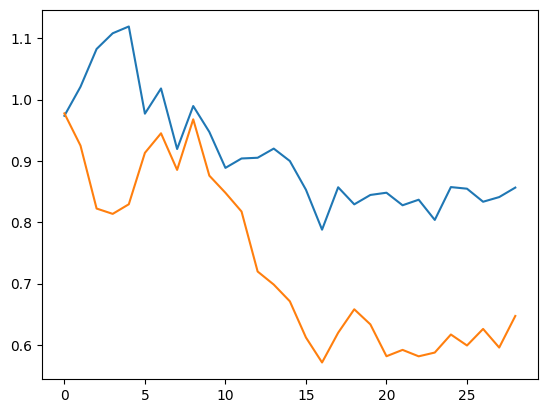

In [14]:
plt.plot([cur_df.iloc[-5][f'target_{i}'] for i in range(1, 30)])
plt.plot(preds)

-----

In [15]:
from catboost import CatBoostRegressor, Pool
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import pickle

pd.options.display.max_columns = 200

In [16]:
all_models = pickle.load(open('models.pkl', 'rb'))

In [17]:
def read_file(path):
    df = pd.read_excel(path)
    df.columns = df.iloc[4]
    df = df.iloc[5:][df.columns[:-1]]

    columns = df.columns.tolist()

    columns[3] = 'продажи'
    columns[16] = 'заболеваемость'
    columns[33] = 'ТВ реклама, руб'
    columns[35] = 'интернет реклама, руб'
    columns[51] = 'wordstat'
    
    df.columns = columns
    df.loc[df['неделя']==53, 'неделя'] = 52

    return df

df = read_file('data/train.xlsx')
df.loc[df['неделя']==53, 'неделя'] = 52

In [18]:
df[df['год'].notna()]

,год,неделя,Начало нед,продажи,"Продажи, рубли","Продажи, упаковки","Продажи, рубли","Продажи, рубли","раствор 0.01 % 150 мл N1, руб","раствор 0.01 % 50 мл N1, руб","раствор 0.01 % 500 мл N1, руб","раствор 0.01 % 150 мл N1, упаковки","раствор 0.01 % 50 мл N1, упаковки","раствор 0.01 % 500 мл N1, упаковки",Дистрибуция Мирамистин,Выписки,заболеваемость,Индекс цены,Развитие Дженериков \n(средняя дистрибуция),Развитие Дженериков \n(кол-во брендов),"(1)\nТВ, trp\n(Ж 30-60 ВС)","(1)\nТВ, рубли","(1)\nТВ, охват 5+\n(Ж 30-60 ВС)","(2)\nТВ, trp\n(Ж 30-60 ВС)","(2)\nТВ, рубли","(2)\nТВ, охват 5+\n(Ж 30-60 ВС)","(3)\nТВ, trp\n(Ж 30-60 ВС)","(3)\nТВ, рубли","(3)\nТВ, охват 5+\n(Ж 30-60 ВС)","(4)\nТВ, trp\n(Ж 30-60 ВС)","(4)\nТВ, рубли","(4)\nТВ, охват 5+\n(Ж 30-60 ВС)","(тотал)\nТВ, trp\n(Ж 30-60 ВС)","ТВ реклама, руб","(тотал)\nТВ, охват 5+\n(Ж 30-60 ВС)","интернет реклама, руб","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, количество выходов",wordstat,"ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб",...,"ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли",Итого,Итого,Итого,Итого,Итого,Итого,Итого,Итого,Итого,Итого,Итого,Итого,Итого
5,2019,1,2018-12-31 00:00:00,41535567.339,0,114621.15,41535567.339,0,0,0,0,0,0,0,0.92107,99698.595433,508956,1.54132,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,0,1057612.5,0,0,0,0,0,0,0,0,0

In [19]:
def create_features(df):

    week_info = df.groupby('неделя')['продажи'].agg(['sum', 'count'])
    week_info.columns = [f'week_{x}' for x in week_info.columns]

    # df = df.merge(week_info, how='left', right_index=True, left_on='неделя')
    # df['week_sum'] -= df['продажи']
    # df['week_count'] -= 1
    # df['feature_mean_week'] = df['week_sum'] / df['week_count']
    # df['feature_mean_week_norm'] = df['feature_mean_week'] / df['продажи'].shift(1)
    # df.drop(['week_sum', 'week_count'], axis=1, inplace=True)

    for i in range(29):
        df[f'target_{i+1}'] = df['продажи'].shift(-i) / df['продажи'].shift(1)

    # week_info_dict = week_info.to_dict()
    for i in range(29):
        df['tmp'] = df['неделя'] + i
        df = df.merge(week_info, how='left', right_index=True, left_on='tmp')
        df['week_sum'] -= df['продажи'].shift(-i)
        df['week_count'] -= 1
        df[f'feature_mean_week_{i}'] = df['week_sum'] / df['week_count'] / 10_000_000
        df[f'feature_mean_week_norm_{i}'] = df[f'feature_mean_week_{i}'] / df['продажи'].shift(1) / 10_000_000
        df.drop(['week_sum', 'week_count'], axis=1, inplace=True)

    df['feature_illnesses'] = df['заболеваемость'].shift(1) / 1_000_000

    df['feature_week'] = df['неделя']

    # for i in range(1, 16, 4):
    #     df[f'feature_month_diff_{i}'] = df['продажи'].shift(i) / df['продажи'].shift(i+4) / 10_000_000

    for i in [7, 13, 20]:
        df[f'feature_big_diff_{i}_weeks'] = df['продажи'].shift(1) / df['продажи'].shift(i) / 10_000_000

    # bad_cols = [col for col in df.columns if 'feature' not in col and 'target' not in col]
    # df.drop(bad_cols, axis=1, inplace=True)
    
    return df

df = create_features(df)
df = df.reset_index(drop=True)

In [20]:
max_id = df[df['target_1'].notna()].index.max()

max_id

243

In [21]:
df['feature_big_diff_13_weeks'].isna().sum()

82

In [22]:
df

,год,неделя,Начало нед,продажи,"Продажи, рубли","Продажи, упаковки","Продажи, рубли","Продажи, рубли","раствор 0.01 % 150 мл N1, руб","раствор 0.01 % 50 мл N1, руб","раствор 0.01 % 500 мл N1, руб","раствор 0.01 % 150 мл N1, упаковки","раствор 0.01 % 50 мл N1, упаковки","раствор 0.01 % 500 мл N1, упаковки",Дистрибуция Мирамистин,Выписки,заболеваемость,Индекс цены,Развитие Дженериков \n(средняя дистрибуция),Развитие Дженериков \n(кол-во брендов),"(1)\nТВ, trp\n(Ж 30-60 ВС)","(1)\nТВ, рубли","(1)\nТВ, охват 5+\n(Ж 30-60 ВС)","(2)\nТВ, trp\n(Ж 30-60 ВС)","(2)\nТВ, рубли","(2)\nТВ, охват 5+\n(Ж 30-60 ВС)","(3)\nТВ, trp\n(Ж 30-60 ВС)","(3)\nТВ, рубли","(3)\nТВ, охват 5+\n(Ж 30-60 ВС)","(4)\nТВ, trp\n(Ж 30-60 ВС)","(4)\nТВ, рубли","(4)\nТВ, охват 5+\n(Ж 30-60 ВС)","(тотал)\nТВ, trp\n(Ж 30-60 ВС)","ТВ реклама, руб","(тотал)\nТВ, охват 5+\n(Ж 30-60 ВС)","интернет реклама, руб","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, количество выходов",wordstat,"ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб",...,Итого,Итого,Итого,Итого,Итого,Итого,Итого,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,target_11,target_12,target_13,target_14,target_15,target_16,target_17,target_18,target_19,target_20,target_21,target_22,target_23,target_24,target_25,target_26,target_27,target_28,target_29,tmp,feature_mean_week_0,feature_mean_week_norm_0,feature_mean_week_1,feature_mean_week_norm_1,feature_mean_week_2,feature_mean_week_norm_2,feature_mean_week_3,feature_mean_week_norm_3,feature_mean_week_4,feature_mean_week_norm_4,feature_mean_week_5,feature_mean_week_norm_5,feature_mean_week_6,feature_mean_week_norm_6,feature_mean_week_7,feature_mean_week_norm_7,feature_mean_week_8,feature_mean_week_norm_8,feature_mean_week_9,feature_mean_week_norm_9,feature_mean_week_10,feature_mean_week_norm_10,feature_mean_week_11,feature_mean_week_norm_11,feature_mean_week_12,feature_mean_week_norm_12,feature_mean_week_13,feature_mean_week_norm_13,feature_mean_week_14,feature_mean_week_norm_14,feature_mean_week_15,feature_mean_week_norm_15,feature_mean_week_16,feature_mean_week_norm_16,feature_mean_week_17,feature_mean_week_norm_17,feature_mean_week_18,feature_mean_week_norm_18,feature_mean_week_19,feature_mean_week_norm_19,feature_mean_week_20,feature_mean_week_norm_20,feature_mean_week_21,feature_mean_week_norm_21,feature_mean_week_22,feature_mean_week_norm_22,feature_mean_week_23,feature_mean_week_norm_23,feature_mean_week_24,feature_mean_week_norm_24,feature_mean_week_25,feature_mean_week_norm_25,feature_mean_week_26,feature_mean_week_norm_26,feature_mean_week_27,feature_mean_week_norm_27,feature_mean_week_28,feature_mean_week_norm_28,feature_illnesses,feature_week,feature_big_diff_7_weeks,feature_big_diff_13_weeks,feature_big_diff_20_weeks
0,2019,1,2018-12-31 00:00:00,41535567.339,0,114621.15,41535567.339,0,0,0,0,0,0,0,0.92107,99698.595433

In [23]:
preds = [df.iloc[max_id]['продажи'] * model.predict(df[model.feature_names_].iloc[max_id+1]) for model in all_models]

sample = pd.DataFrame({
    'week': ['04.09.2023', '11.09.2023', '18.09.2023', '25.09.2023', '02.10.2023', '09.10.2023', '16.10.2023', '23.10.2023', '30.10.2023', '06.11.2023', '13.11.2023', '20.11.2023', '27.11.2023', '04.12.2023', '11.12.2023', '18.12.2023', '25.12.2023', '01.01.2024', '08.01.2024', '15.01.2024', '22.01.2024', '29.01.2024', '05.02.2024', '12.02.2024', '19.02.2024', '26.02.2024', '04.03.2024', '11.03.2024', '18.03.2024'],
    'revenue': preds
})

sample

,week,revenue
0,04.09.2023,5.852031e+07
1,11.09.2023,5.362082e+07
2,18.09.2023,5.115467e+07
3,25.09.2023,4.897608e+07
4,02.10.2023,4.778789e+07
5,09.10.2023,4.853663e+07
6,16.10.2023,5.530249e+07
7,23.10.2023,5.396723e+07
8,30.10.2023,5.013609e+07
9,06.11.2023,4.893326e+07


In [24]:
prev = df[df['продажи'].notna()]['продажи'].tolist()

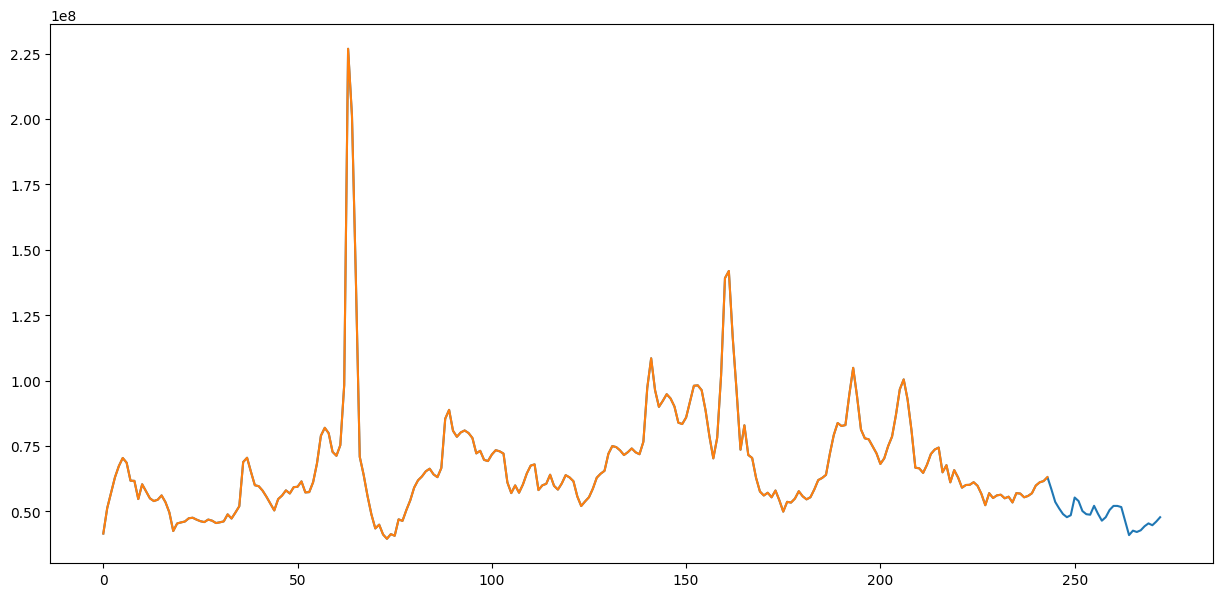

In [25]:
plt.figure(figsize=(15, 7))

plt.plot(prev + preds)
plt.plot(prev)

In [26]:
prev

[41535567.338999964,
 51222286.227000006,
 57127348.90799998,
 63040990.93950002,
 67336888.86750002,
 70424479.9545,
 68621184.93300007,
 61742982.70350003,
 61669241.686500005,
 54711731.21400006,
 60370834.18800002,
 57711047.93999998,
 54984651.26700004,
 53957100.97050005,
 54465673.57350004,
 56102193.06300003,
 53522514.769499965,
 49595583.16650007,
 42497605.752000004,
 45385737.547499985,
 45787518.13649999,
 46130274.30899997,
 47373923.06849999,
 47580378.55199999,
 46851319.504499994,
 46248933.51749998,
 45910321.065,
 46879679.70000002,
 46447160.056499965,
 45545038.99050008,
 45828373.647000015,
 46180807.48050001,
 48863738.112000026,
 47269759.00499999,
 49555107.10500006,
 51982737.99600003,
 68873074.65150003,
 70505388.77550001,
 65132318.19150002,
 60006025.81050006,
 59637796.270500004,
 57930762.3615,
 55576825.00649996,
 52992172.274999976,
 50367878.20049999,
 54698274.22499996,
 56055933.38099999,
 58039938.02249994,
 56847955.961999975,
 59259533.47649997,
